In [1]:
%load_ext autoreload
%autoreload 2

# MTBO Baumgartner Study

In [2]:
from summit.strategies import STBO,MTBO, Transform, LHS, Chimera
from summit.benchmarks import BaumgartnerCrossCouplingEmulator
from summit.utils.dataset import DataSet
from summit.domain import *
import summit
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from IPython.display import clear_output

## Get data

In [3]:
# Path to data
summit_path = pathlib.Path(summit.__file__).parents[0]
data_path = summit_path / "benchmarks" / "experiment_emulator" / "data"

In [4]:
# Import Pd-catalyzed cross-coupling Data
benzamide_data = DataSet.read_csv(data_path / f"baumgartenter_benzamide_cross_coupling.csv")
benzamide_data[('task', 'METADATA')] = 0
benzamide_data.tail(5)

,catalyst,base,base_equivalents,temperature,t_res,yld,task
54,tBuBrettPhos,MTBD,2.07586,100,636.969,0.966453944,0
55,tBuBrettPhos,BTMG,1.4713,86.2,591.908,0.975057179,0
56,tBuBrettPhos,MTBD,1.43218,86.6,675.34,≥90%,0
57,tBuBrettPhos,DBU,1.45246,86.4,743.305,0.53850977,0
58,tBuBrettPhos,DBU,1.03527,91.3,739.324,0.497285043,0


In [5]:
# Drop base=MTBD because not in other dataset
benzamide_data = benzamide_data[benzamide_data['base'] != "MTBD"]

In [6]:
# Clean data
benzamide_data = benzamide_data.replace("≥90%", 0.9)

## Optimization

In [3]:
N_REPEATS = 10
MAX_ITERATIONS = 20

In [4]:
exp = BaumgartnerCrossCouplingEmulator()
exp.domain

Name,Type,Description,Values
catalyst,"categorical, input",Catalyst type,3 levels
base,"categorical, input",Base,4 levels
base_equivalents,"continuous, input",Base equivalents,"[1.0,2.5]"
temperature,"continuous, input",Temperature in degrees Celsius (ºC),"[30,100]"
t_res,"continuous, input",residence time in seconds (s),"[60,1800]"
yld,"continuous, maximize objective",Yield,"[0.0,1.0]"


### Single Task Optimization

In [5]:
def run_stbo(max_iterations=10, categorical_method="one-hot"):
    exp = BaumgartnerCrossCouplingEmulator()
    exp.reset()
    strategy = STBO(exp.domain, 
                    categorical_method=categorical_method)
    r = summit.Runner(strategy=strategy, 
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

In [27]:
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    result = run_stbo(MAX_ITERATIONS)
    result.save(f"data/stbo_repeat_{i}.json")
    clear_output(wait=True)

Repeat 9


### Multitask Optimization

In [25]:
def run_mtbo(max_iterations=10):
    exp.reset()
    strategy = MTBO(exp.domain, 
                    pretraining_data=benzamide_data,
                    categorical_method="one-hot", 
                    task=1)
    r = summit.Runner(strategy=strategy,
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

In [28]:
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    result = run_mtbo(MAX_ITERATIONS)
    result.save(f"data/mtbo_repeat_{i}.json")
    clear_output(wait=True)

Repeat 9


### Visualize Results

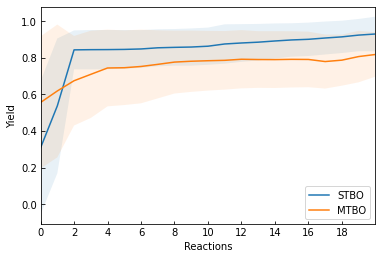

In [12]:
stbo_results = [summit.Runner.load(f"data/stbo_repeat_{i}.json") for i in range(10)]
mtbo_results = [summit.Runner.load(f"data/mtbo_repeat_{i}.json") for i in range(10)]
def make_average_plot(results: List[summit.Runner], ax, label=None, color=None):
    yields = [r.experiment.data['yld'] for r in results]
    yields = np.array(yields)
    mean_yield = np.mean(yields, axis=0)
    std_yield = np.std(yields, axis=0)
    x = np.arange(0, len(mean_yield), 1).astype(int)
    ax.plot(x, mean_yield, label=label)
    ax.fill_between(x, mean_yield-std_yield, mean_yield+std_yield, alpha=0.1)
#     ax.errorbar(x,mean_yield, std_yield, 
#                 label=label, marker='o', capsize=5, c=color, alpha=0)
    
fig, ax = plt.subplots(1)
make_average_plot(stbo_results, ax, label="STBO", color='r')
make_average_plot(mtbo_results, ax, label="MTBO", color='b')
ax.legend(loc = "lower right")
ax.set_xlim(0,20)
ax.set_xticks(np.arange(0, 20, 2).astype(int))
ax.set_ylabel('Yield')
ax.set_xlabel('Reactions')
ax.tick_params(direction='in')
fig.savefig("figures/stbo_mtbo_comparison.png")